# Домашняя работа №2
# Решение в конце ноутбука

## Задача: классификация твитов по тональности

У нас есть датасет из твитов, про каждый указано, как он эмоционально окрашен: положительно или отрицательно. Задача: предсказывать эмоциональную окраску.

Скачиваем куски датасета ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv).

In [153]:
# # если у вас линукс / мак / collab или ещё какая-то среда, в которой работает wget, можно так:
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

--2022-10-15 13:15:24--  https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/fnpq3z4bcnoktiv/positive.csv [following]
--2022-10-15 13:15:24--  https://www.dropbox.com/s/raw/fnpq3z4bcnoktiv/positive.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc3e12ec062e5dca2c06b9e75cb.dl.dropboxusercontent.com/cd/0/inline/Bu2eAfBM0nyTYNXAJuxCSKrfnf4keuSKst-efzcS4AxbTtmpKc6cIuObUe9TNmBLs7C-mWADwfNnR7Z4Ykr2PZq3L6gUnSalZaWMMK1APakxJcBCYhKZGv9a9750tGJcnv4ubZ3x_MH8jLdvF6w-ZbHzZhuAEF778Z24s6TySNqsYw/file# [following]
--2022-10-15 13:15:25--  https://ucc3e12ec062e5dca2c06b9e75cb.dl.dropboxusercontent.com/cd/0/inline/Bu2eAfBM0nyTYNXAJuxCSKrfnf4keuSKst-efzcS4AxbTtmpKc6cIuObUe9TNmBLs7C-mWADwfNnR

In [154]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn import model_selection, preprocessing, linear_model
from nltk import collocations
from nltk.tokenize import word_tokenize
from nltk import tokenize as tknz
import nltk
from collections import Counter
from sklearn.linear_model import LogisticRegression

In [155]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)


In [156]:
df.tail()

,text,label
111918,Но не каждый хочет что то исправлять:( http://...,negative
111919,скучаю так :-( только @taaannyaaa вправляет мо...,negative
111920,"Вот и в школу, в говно это идти уже надо(",negative
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",negative
111922,Такси везет меня на работу. Раздумываю приплат...,negative


In [157]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

In [158]:
y_test.value_counts()

positive    28917
negative    27792
Name: label, dtype: int64

## Baseline: классификация необработанных n-грамм

### Векторизаторы

In [159]:
from sklearn.linear_model import LogisticRegression # можно заменить на любимый классификатор
from sklearn.feature_extraction.text import CountVectorizer

Что такое n-граммы:

In [160]:
from nltk import ngrams

In [161]:
sent = 'Если б мне платили каждый раз'.split()
list(ngrams(sent, 1)) # униграммы

[('Если',), ('б',), ('мне',), ('платили',), ('каждый',), ('раз',)]

In [162]:
list(ngrams(sent, 2)) # биграммы

[('Если', 'б'),
 ('б', 'мне'),
 ('мне', 'платили'),
 ('платили', 'каждый'),
 ('каждый', 'раз')]

In [163]:
list(ngrams(sent, 3)) # триграммы

[('Если', 'б', 'мне'),
 ('б', 'мне', 'платили'),
 ('мне', 'платили', 'каждый'),
 ('платили', 'каждый', 'раз')]

In [164]:
list(ngrams(sent, 5)) # ... пентаграммы?

[('Если', 'б', 'мне', 'платили', 'каждый'),
 ('б', 'мне', 'платили', 'каждый', 'раз')]

Самый простой способ извлечь фичи из текстовых данных -- векторизаторы: `CountVectorizer` и `TfidfVectorizer`

Объект `CountVectorizer` делает простую вещь:
* строит для каждого документа (каждой пришедшей ему строки) вектор размерности `n`, где `n` -- количество слов или n-грам во всём корпусе
* заполняет каждый i-тый элемент количеством вхождений слова в данный документ

In [165]:
vec = CountVectorizer(ngram_range=(1, 1))


ngram_range отвечает за то, какие n-граммы мы используем в качестве фичей:<br/>
ngram_range=(1, 1) -- униграммы<br/>
ngram_range=(3, 3) -- триграммы<br/>
ngram_range=(1, 3) -- униграммы, биграммы и триграммы.

In [166]:
vec

CountVectorizer()

In [167]:
vec.fit_transform(x_train)

<170125x243759 sparse matrix of type '<class 'numpy.int64'>'
	with 1848380 stored elements in Compressed Sparse Row format>

In [168]:
vec

CountVectorizer()

In [169]:
bow = vec.fit_transform(x_train) # bow -- bag of words (мешок слов)

В vec.vocabulary_ лежит словарь: мэппинг слов к их индексам:

In [170]:
vec.vocabulary_

{'mashashatskaya': 56398,
 'еще': 130671,
 'под': 184603,
 'теплым': 221336,
 'одеялом': 172423,
 '18': 1102,
 'жесть': 131440,
 'rt': 74572,
 'zabillikitarov': 95954,
 'блять': 106600,
 'нам': 163351,
 'уже': 226573,
 'пешеходовы': 181960,
 'забивают': 132497,
 'всю': 115888,
 'жизнь': 131633,
 'слушала': 211393,
 'rap': 72600,
 'тут': 224610,
 'что': 237650,
 'то': 222143,
 'на': 161758,
 'rock': 73960,
 'подсела': 185796,
 'taigozin': 82140,
 'меня': 157626,
 'было': 109317,
 'трудное': 224023,
 'детство': 125028,
 'мне': 159163,
 'покупали': 187355,
 'обувь': 171537,
 'вырос': 117685,
 'говорили': 120423,
 'жун': 132160,
 'носкимен': 169233,
 'нормально': 169142,
 'болады': 106997,
 'проснулась': 197192,
 '11': 672,
 'концерт': 147547,
 'два': 123539,
 'раза': 199710,
 'выступаем': 117971,
 'волнуюсь': 114147,
 'главное': 119880,
 'чтоб': 237653,
 'всё': 115918,
 'прошло': 197891,
 'гладко': 119921,
 'hamsters_win': 36311,
 'ты': 224735,
 'ничего': 168527,
 'не': 165416,
 'сделаешь

In [171]:
list(vec.vocabulary_.items())[:10]

[('mashashatskaya', 56398),
 ('еще', 130671),
 ('под', 184603),
 ('теплым', 221336),
 ('одеялом', 172423),
 ('18', 1102),
 ('жесть', 131440),
 ('rt', 74572),
 ('zabillikitarov', 95954),
 ('блять', 106600)]

In [172]:
vec.get_feature_names()

['00',
 '000',
 '0000',
 '00000',
 '000000',
 '0000000',
 '0000000000',
 '0000000000000000',
 '00000000000000000',
 '00000098',
 '000009',
 '00099скобкаскобка',
 '000nana000',
 '000р',
 '000руб',
 '000тн',
 '001',
 '002',
 '0022',
 '003',
 '003r38hn6e',
 '004anna',
 '004hafarf4',
 '007',
 '0080',
 '008ge0nygh',
 '008novublr',
 '00_anita_00',
 '00_elenka',
 '00_orekhova',
 '00c6a95bst',
 '00darya',
 '00dwpheuip',
 '00ennqulcp',
 '00fedosova',
 '00gorbunova',
 '00kudrina',
 '00lg6bsnb8',
 '00ngi3vmps',
 '00okaay',
 '00pm',
 '00shepelevich',
 '00svy9tdoo',
 '00uz4ysuew',
 '00victoria16',
 '00vlass',
 '00w8hqz74x',
 '00ynu1l1f3',
 '00отак',
 '00я',
 '01',
 '010',
 '01_nastyaa',
 '01baidina',
 '01bxl20qjf',
 '01dina89',
 '01e766j8rh',
 '01fcpfr7q1',
 '01foreveryoung',
 '01huixufjf',
 '01nushka',
 '01sickdreamer',
 '01yqi8ki1v',
 '01znllh',
 '01цитата',
 '02',
 '023sm',
 '0280022',
 '029',
 '02_soft',
 '02afkidc1z',
 '02azobova',
 '02h1za2mlh',
 '02new_york1',
 '02p17',
 '02sona',
 '02swolt4

In [173]:
# # Размер матрицы признаков (170125, 244271). Код не отрабатывается
# bow.toarray().shape()

In [174]:
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)

LogisticRegression(random_state=42)

In [175]:
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.77      0.76      0.76     28219
    positive       0.76      0.77      0.77     28490

    accuracy                           0.77     56709
   macro avg       0.77      0.77      0.77     56709
weighted avg       0.77      0.77      0.77     56709



Попробуем сделать то же самое для триграмм:

In [176]:
vec = CountVectorizer(ngram_range=(3, 3))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.84      0.57      0.68     41069
    positive       0.39      0.72      0.51     15640

    accuracy                           0.61     56709
   macro avg       0.62      0.65      0.59     56709
weighted avg       0.72      0.61      0.63     56709



(как вы думаете, почему в результатах теперь такой разброс по сравнению с униграммами?)

## TF-IDF векторизация

`TfidfVectorizer` делает то же, что и `CountVectorizer`, но в качестве значений – tf-idf каждого слова.

Как считается tf-idf:

TF (term frequency) – относительная частотность слова в документе:
$$ TF(t,d) = \frac{n_t}{\sum_k n_k} $$

`t` -- слово (term), `d` -- документ, $n_t$ -- количество вхождений слова, $n_k$ -- количество вхождений остальных слов

IDF (inverse document frequency) – обратная частота документов, в которых есть это слово:
$$ IDF(t, D) = \mbox{log} \frac{|D|}{|{d : t \in d}|} $$

`t` -- слово (term), `D` -- коллекция документов

Перемножаем их:
$$TFIDF_(t,d,D) = TF(t,d) \times IDF(i, D)$$



### Сакральный смысл – если слово часто встречается в одном документе, но в целом по корпусу встречается в небольшом количестве документов, у него высокий TF-IDF. Добавка от меня: и поэтому он обладает высокой предсказательной способностью

In [177]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [178]:
vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.74      0.77      0.75     26689
    positive       0.78      0.76      0.77     30020

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



В этот раз получилось хуже :( Вернёмся к `CountVectorizer`.

## PMI

Можно оценить взаимосвязь слов в корпусе и понять, какие биграммы наиболее часто встречаются в тексте. Для этого можно использовать метрику PMI (Pointwise Mutual Information) - поточечная взаимная информация. Метрика PMI для двух слов вычисляется по формуле:

$$pmi(x; y) = log \frac{p(x,y)}{p(x)p(y)} $$

Здесь p(y|x) - вероятность встретить слово $y$ после $x$, $p(y)$ - вероятность встретить слово $y$.

Оценим важность биграмм в нашем обучающем корпусе.

In [179]:
from nltk import collocations
from nltk.tokenize import word_tokenize
from nltk import tokenize as tknz
import nltk
nltk.download('genesis', "C:/Users/60053972/AppData/Roaming/nltk_data")
nltk.download('punkt', "C:/Users/60053972/AppData/Roaming/nltk_data")
nltk.download('genesis')
nltk.download('punkt')


[nltk_data] Downloading package genesis to
[nltk_data]     C:/Users/60053972/AppData/Roaming/nltk_data...
[nltk_data]   Package genesis is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:/Users/60053972/AppData/Roaming/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package genesis to /root/nltk_data...
[nltk_data]   Package genesis is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [180]:
print(type(nltk.corpus.genesis.words('english-web.txt')))
bigram_measures = collocations.BigramAssocMeasures()
# bigram_finder.apply_freq_filter(5)
bigram_finder = collocations.BigramCollocationFinder.from_documents([nltk.word_tokenize(x) for x in x_train])
bigrams = bigram_finder.nbest(bigram_measures.pmi, 100)
print(bigrams)

<class 'nltk.corpus.reader.util.StreamBackedCorpusView'>
[('+1239', '728'), ('+380967389762', 'СПАСИБО:3'), ('+Никита', '=полностью'), ('+СОННО', '+НЕ'), ('+живіт', 'болить.ну'), ('+погода', 'крутая='), (',Дела', 'рез'), ('-10,11', 'болсо'), ('-163', '-КРАСНЫЙ'), ('-165', '-СИНИЙ'), ('-53', 'dBm'), ('-АХАХАХАХ', 'ЮБКУ'), ('-АХАХАХАХХАХАХАХАХАХХА', '-АХАХАХХАХАХАХАХАХ'), ('-Алина', '-Синие'), ('-Аха', 'спетросянил'), ('-ВАХАХАХА', 'СТИПЕНДИЯ'), ('-Весело', 'кншн:3'), ('-Восьмигрудый', 'трипи'), ('-ГНИДОТА', '-Над'), ('-Д-Д-Д-Д-Д-Д-ДРОП', 'ЗЭ'), ('-ДЕТЕЙ', 'НАКРЫЛО'), ('-ДОВАЙТИ', 'АЛДСКУЛ'), ('-Дирол', 'Сенсес'), ('-Домашка', '-кл.час'), ('-Дядь', 'Юр'), ('-ЖАРЕНЫЙ', 'КАРТОФЕЛЬ'), ('-ЖРАТЬ', 'БАРАНКИ'), ('-ЗАШЛА', 'ОДЕЛА'), ('-Защитано', '-ес'), ('-Зелено-карие', '-Киллджой'), ('-КРАСНЫЙ', '-ЧЕРНЫЕ'), ('-Керем', 'севгили'), ('-Киллджой', '-Котик'), ('-Корнейчук', 'затроллила'), ('-МНОГО', 'СЛИВОК'), ('-Маладец', '-Лол'), ('-Мамаааа', 'поправь'), ('-НА', 'РЕАЛЬНЫХ'), ('-НАЧИНАЕТ', 'БЕСИТ

Можно рассмотреть другие метрики оценки важности биграмм, например, метрику правдоподобия (подробнее про вычисление метрики можно посмотреть [здесь (пункт 5.3.4)](http://www.corpus.unam.mx/cursoenah/ManningSchutze_1999_FoundationsofStatisticalNaturalLanguageProcessing.pdf):

In [181]:
bigrams = bigram_finder.nbest(bigram_measures.likelihood_ratio, 100)
print(bigrams)

[('(', '('), ('RT', '@'), (')', ')'), ('http', ':'), ('!', '!'), (':', 'D'), ('у', 'меня'), (':', '('), (',', 'а'), (',', 'что'), (',', 'но'), (')', 'http'), ('*', '*'), (':', ')'), ('у', 'нас'), ('(', ','), (':', '-'), (',', '('), ('?', '?'), ('не', 'могу'), (',', ')'), (')', ','), (',', ':'), ('@', '('), (',', ','), (':', ','), ('(', ':'), ('&', 'lt'), ('@', ','), ('со', 'мной'), ('@', ':'), ('(', '@'), (':', ':'), ('gt', ';'), (';', ')'), ('новый', 'год'), (',', '@'), (':', '*'), (')', ':'), ('а', 'я'), ('не', 'знаю'), ('потому', 'что'), ('@', '@'), ('У', 'меня'), ('lt', ';'), (',', 'когда'), ('сих', 'пор'), ('&', 'gt'), ('у', 'тебя'), (';', '('), ('все', 'равно'), ('с', 'тобой'), (',', 'как'), ('в', 'школу'), ('&', 'amp'), ('ничего', 'не'), ('(', 'http'), ('Доброе', 'утро'), (')', '@'), ('-', ')'), (',', 'я'), ('Как', 'же'), (':', 'DD'), ('я', 'не'), ('не', '('), ('самом', 'деле'), ('как', 'же'), ('amp', ';'), ('не', ')'), ('до', 'сих'), ('(', '!'), (',', 'чтобы'), (',', '!'), ('об

Как можно заметить, немаловажную роль в текстах занимает пунктуация.

## Стоп-слова и пунктуация

*Стоп-слова* -- это слова, которые часто встречаются практически в любом тексте и ничего интересного не говорят о конретном документе, то есть играют роль шума. Поэтому их принято убирать. По той же причине убирают и пунктуацию.

In [182]:
# у вас здесь, вероятно, выскочит ошибка и надо будет загрузить стоп слова (в тексте ошибки написано, как)
from nltk.corpus import stopwords
nltk.download('stopwords')
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [183]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [184]:
noise = stopwords.words('russian') + list(punctuation)

В векторизаторах за стоп-слова, логичным образом, отвечает аргумент `stop_words`.

In [185]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.80      0.76      0.78     29237
    positive       0.76      0.80      0.78     27472

    accuracy                           0.78     56709
   macro avg       0.78      0.78      0.78     56709
weighted avg       0.78      0.78      0.78     56709



Получилось чууть лучше. Что ещё можно сделать?

## Лемматизация

Лемматизация – это сведение разных форм одного слова к начальной форме – *лемме*. Почему это хорошо?
* Во-первых, мы хотим рассматривать как отдельную фичу каждое *слово*, а не каждую его отдельную форму.
* Во-вторых, некоторые стоп-слова стоят только в начальной форме, и без лематизации выкидываем мы только её.

Для русского есть два хороших лемматизатора: mystem и pymorphy:

### [Mystem](https://tech.yandex.ru/mystem/)
Как с ним работать:
* можно скачать mystem и запускать [из терминала с разными параметрами](https://tech.yandex.ru/mystem/doc/)
* [pymystem3](https://pythonhosted.org/pymystem3/pymystem3.html) - обертка для питона, работает медленнее, но это удобно

In [186]:
# !wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
# !tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
# !cp mystem /bin

In [187]:
from pymystem3 import Mystem
mystem_analyzer = Mystem()

Мы инициализировали Mystem c дефолтными параметрами. А вообще параметры есть такие:
* mystem_bin - путь к `mystem`, если их несколько
* grammar_info - нужна ли грамматическая информация или только леммы (по дефолту нужна)
* disambiguation - нужно ли снятие омонимии - дизамбигуация (по дефолту нужна)
* entire_input - нужно ли сохранять в выводе все (пробелы всякие, например), или можно выкинуть (по дефолту оставляется все)

Методы Mystem принимают строку, токенизатор вшит внутри. Можно, конечно, и пословно анализировать, но тогда он не сможет учитывать контекст.

Можно просто лемматизировать текст:

In [188]:
# example = 'Но не каждый хочет что-то исправлять'
# print(mystem_analyzer.lemmatize(example))

А можно получить грамматическую информацию:

In [189]:
# mystem_analyzer.analyze(example)

Давайте терепь используем лемматизатор майстема в качестве токенизатора.

In [190]:
import re
def my_preproc(text):
    text = re.sub('[{}]'.format(punctuation), '', text)
    text = mystem_analyzer.lemmatize(text)
    return [word for word in text if word not in stopwords.words('russian') + [' ', '\n']]

In [191]:
#vec = CountVectorizer(ngram_range=(1, 1), tokenizer=my_preproc)
#bow = vec.fit_transform(x_train)
#clf = LogisticRegression(random_state=42)
#clf.fit(bow, y_train)
#pred = clf.predict(vec.transform(x_test))
#print(classification_report(pred, y_test))

### [Pymorphy](http://pymorphy2.readthedocs.io/en/latest/)
Это модуль на питоне, довольно быстрый и с кучей функций.

In [192]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [193]:
from pymorphy2 import MorphAnalyzer
pymorphy2_analyzer = MorphAnalyzer()

pymorphy2 работает с отдельными словами. Если дать ему на вход предложение - он его просто не лемматизирует, т.к. не понимает

In [194]:
example = ['Но', 'не', 'каждый', 'хочет', 'что-то', 'исправлять'] 
ana = pymorphy2_analyzer.parse(example[3])
ana

[Parse(word='хочет', tag=OpencorporaTag('VERB,impf,tran sing,3per,pres,indc'), normal_form='хотеть', score=1.0, methods_stack=((DictionaryAnalyzer(), 'хочет', 3136, 5),))]

In [195]:
ana[0].normal_form

'хотеть'

### [Natasha](https://github.com/natasha/)

В библиотеке natasha реализовано множество полезных библиотек для русского языка: разбиение на токены и предложения, русскоязычные word embeddings, морфологический, синтаксический анализ, лемматизация, извлечение именованных сущностей и т.д. Модуль библиотеки Razdel, основанный на правилах, предназначен для разбиения текста на токены и предложения.

In [196]:
 !pip install razdel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [197]:
from razdel import tokenize

tokens = list(tokenize('Кружка-термос на 0.5л (50/64 см³, 516;...)'))
tokens

[Substring(0, 13, 'Кружка-термос'),
 Substring(14, 16, 'на'),
 Substring(17, 20, '0.5'),
 Substring(20, 21, 'л'),
 Substring(22, 23, '('),
 Substring(23, 28, '50/64'),
 Substring(29, 32, 'см³'),
 Substring(32, 33, ','),
 Substring(34, 37, '516'),
 Substring(37, 38, ';'),
 Substring(38, 41, '...'),
 Substring(41, 42, ')')]

In [198]:
[_.text for _ in tokens]

['Кружка-термос',
 'на',
 '0.5',
 'л',
 '(',
 '50/64',
 'см³',
 ',',
 '516',
 ';',
 '...',
 ')']

In [199]:
!pip install natasha

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


С помощью библиотеки natasha можно также лемматизировать тексты.

In [200]:
from natasha import Doc, MorphVocab, Segmenter, NewsEmbedding, NewsMorphTagger

segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

def natasha_lemmatize(text):
  doc = Doc(text)
  doc.segment(segmenter)
  doc.tag_morph(morph_tagger)
  for token in doc.tokens:
    token.lemmatize(morph_vocab)
  return {_.text: _.lemma for _ in doc.tokens}

In [201]:
text = 'Посол Израиля на Украине Йоэль Лион признался, что пришел в шок, узнав о решении властей Львовской области объявить 2019 год годом лидера запрещенной в России Организации украинских националистов (ОУН) Степана Бандеры. Свое заявление он разместил в Twitter. «Я не могу понять, как прославление тех, кто непосредственно принимал участие в ужасных антисемитских преступлениях, помогает бороться с антисемитизмом и ксенофобией. Украина не должна забывать о преступлениях, совершенных против украинских евреев, и никоим образом не отмечать их через почитание их исполнителей», — написал дипломат. 11 декабря Львовский областной совет принял решение провозгласить 2019 год в регионе годом Степана Бандеры в связи с празднованием 110-летия со дня рождения лидера ОУН (Бандера родился 1 января 1909 года). В июле аналогичное решение принял Житомирский областной совет. В начале месяца с предложением к президенту страны Петру Порошенко вернуть Бандере звание Героя Украины обратились депутаты Верховной Рады. Парламентарии уверены, что признание Бандеры национальным героем поможет в борьбе с подрывной деятельностью против Украины в информационном поле, а также остановит «распространение мифов, созданных российской пропагандой». Степан Бандера (1909-1959) был одним из лидеров Организации украинских националистов, выступающей за создание независимого государства на территориях с украиноязычным населением. В 2010 году в период президентства Виктора Ющенко Бандера был посмертно признан Героем Украины, однако впоследствии это решение было отменено судом. '

natasha_lemmatize(text)

{'Посол': 'посол',
 'Израиля': 'израиль',
 'на': 'на',
 'Украине': 'украина',
 'Йоэль': 'йоэль',
 'Лион': 'лион',
 'признался': 'признаться',
 ',': ',',
 'что': 'что',
 'пришел': 'прийти',
 'в': 'в',
 'шок': 'шок',
 'узнав': 'узнать',
 'о': 'о',
 'решении': 'решение',
 'властей': 'власть',
 'Львовской': 'львовский',
 'области': 'область',
 'объявить': 'объявить',
 '2019': '2019',
 'год': 'год',
 'годом': 'год',
 'лидера': 'лидер',
 'запрещенной': 'запретить',
 'России': 'россия',
 'Организации': 'организация',
 'украинских': 'украинский',
 'националистов': 'националист',
 '(': '(',
 'ОУН': 'оун',
 ')': ')',
 'Степана': 'степан',
 'Бандеры': 'бандера',
 '.': '.',
 'Свое': 'свой',
 'заявление': 'заявление',
 'он': 'он',
 'разместил': 'разместить',
 'Twitter': 'twitter',
 '«': '«',
 'Я': 'я',
 'не': 'не',
 'могу': 'мочь',
 'понять': 'понять',
 'как': 'как',
 'прославление': 'прославление',
 'тех': 'тот',
 'кто': 'кто',
 'непосредственно': 'непосредственно',
 'принимал': 'принимать',
 'уча

### mystem vs. pymorphy vs. natasha

1) *Мы надеемся, что вы пользуетесь линуксом*, но mystem работает невероятно медленно под windows на больших текстах.

2) *Снятие омонимии*. Mystem умеет снимать омонимию по контексту (хотя не всегда преуспевает), pymorphy2 берет на вход одно слово и соответственно вообще не умеет дизамбигуировать по контексту, natasha тоже с этим тоже не справляется успешно:

In [202]:
homonym1 = 'За время обучения я прослушал больше сорока курсов.'
homonym2 = 'Сорока своровала блестящее украшение со стола.'

In [203]:
#mystem_analyzer = Mystem() # инициализирую объект с дефолтными параметрами
#print(mystem_analyzer.analyze(homonym1)[-5])
#print(mystem_analyzer.analyze(homonym2)[0])

In [204]:
#print(natasha_lemmatize(homonym1))

In [205]:
#print(natasha_lemmatize(homonym2))

## Словарь, закон Ципфа и закон Хипса

Закон Ципфа -- эмпирическая закономерность: если все слова корпуса текста упорядочить по убыванию частоты их использования, то частота n-го слова в таком списке окажется приблизительно обратно пропорциональной его порядковому номеру n. Иными словами, частотность слов убывает очень быстро.

In [206]:
from collections import Counter

In [207]:
corpus = [token for tweet in df.text for token in word_tokenize(tweet) if token not in punctuation]
print(len(corpus))
corpus[:10]

2870536


['first_timee', 'хоть', 'я', 'и', 'школота', 'но', 'поверь', 'у', 'нас', 'то']

In [208]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('не', 69472),
 ('и', 55166),
 ('в', 52902),
 ('я', 52818),
 ('RT', 38070),
 ('на', 35759),
 ('http', 32998),
 ('что', 31541),
 ('с', 27217),
 ('а', 26860)]

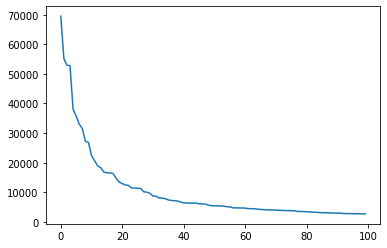

In [209]:
import matplotlib.pyplot as plt
%matplotlib inline
first_100_freqs = [freq for word, freq in freq_dict_sorted[:100]]
plt.plot(first_100_freqs)
plt.show()

Закон Хипса - обратная сторона закона Ципфа. Он описывает, что чем больше корпус, тем меньше новых слов добавляется с добавлением новых текстов. В какой-то момент корпус насыщается.

## Задание 1

**Задание**: обучите три классификатора: 

1) на токенах с высокой частотой 

2) на токенах со средней частотой 

3) на токенах с низкой частотой

Сравните полученные результаты, оцените какие токены наиболее важные для классификации.

In [210]:
from natasha import Doc, MorphVocab, Segmenter, NewsEmbedding, NewsMorphTagger

segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

def natasha_lemmatize(text):
  doc = Doc(text)
  doc.segment(segmenter)
  doc.tag_morph(morph_tagger)
  for token in doc.tokens:
    token.lemmatize(morph_vocab)
  return [_.lemma for _ in doc.tokens]

In [211]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [212]:
# у вас здесь, вероятно, выскочит ошибка и надо будет загрузить стоп слова (в тексте ошибки написано, как)
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [213]:
noise = stopwords.words('russian') + list(punctuation)

В векторизаторах за стоп-слова, логичным образом, отвечает аргумент `stop_words`.

In [214]:
# # Можно с natasha_lemmatize, но это долго
# vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=noise)
# bow = vec.fit_transform(x_train[:1000])
# clf = LogisticRegression(random_state=42)
# clf.fit(bow, y_train[:1000])
# pred = clf.predict(vec.transform(x_test))
# print(classification_report(pred, y_test))

In [215]:
# Обучим модель на токенах с низкой частотой (удалим из разряженной матрицы слова, которые встречаются более чем в 2000 документах  - около 1%)
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=noise, max_df = 2000)
bow = vec.fit_transform(x_train)

In [216]:
# Количество слов оставшихся в разряженной матрице
len(vec.get_feature_names())

259638

In [217]:
# Обучим модель
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.76      0.74      0.75     28494
    positive       0.74      0.76      0.75     28215

    accuracy                           0.75     56709
   macro avg       0.75      0.75      0.75     56709
weighted avg       0.75      0.75      0.75     56709



In [218]:
# Обучим модель на токенах с высокой частотой (удалим из разряженной матрицы слова, которые встречаются менее чем в 70 документах)
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=noise, min_df = 70)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.75      0.71      0.73     29447
    positive       0.71      0.75      0.73     27262

    accuracy                           0.73     56709
   macro avg       0.73      0.73      0.73     56709
weighted avg       0.73      0.73      0.73     56709



In [219]:
# Количество слов оставшихся в разряженной матрице
len(vec.get_feature_names())

2292

In [220]:
# Обучим модель на токенах со средней частотой (удалим из разряженной матрицы слова, которые встречаются более чем в 2000 документах, но менее чем в 70)
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=noise, min_df = 70, max_df = 2000)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.62      0.71      0.66     24295
    positive       0.76      0.67      0.71     32414

    accuracy                           0.69     56709
   macro avg       0.69      0.69      0.69     56709
weighted avg       0.70      0.69      0.69     56709



In [221]:
# Количество слов оставшихся в разряженной матрице
len(vec.get_feature_names())

2261

Вывод: для классификации именно твитов наибольшее пргностичнеское значение имеют токены с низкой частотой встречаемости в документах. Но нужно учитывать, что их просто мало. Если довести их значение до 14 тыс. (Токены при встречаемости менее чем в 10 документах), то они показывают лучший результат классификации, чем токены с низкой частотой

## Задание 2

Найти фичи с наибольшей значимостью, и вывести их

In [222]:
# Обучим модель на всех признаках
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.80      0.76      0.78     29237
    positive       0.76      0.80      0.78     27472

    accuracy                           0.78     56709
   macro avg       0.78      0.78      0.78     56709
weighted avg       0.78      0.78      0.78     56709



In [223]:
# В модели логисчической регрессии важность признака определяется величиной коэффициента припризнаке. Воспользуемся этим и определим 20 наиболее значимых признака
features = pd.DataFrame(clf.coef_[0], 
                        vec.get_feature_names(), 
                        columns=['coefficient']).sort_values('coefficient', ascending = False)
features.head(20)

,coefficient
d,6.055297
^_^,5.026249
ddd,4.407320
dd,4.130908
xd,3.401448
dddd,3.346632
ddddd,3.161551
-d,2.684766
отличного,2.566330
х,2.468890


Посмотрим на частоту встречаемости этих наиболее важных признаков

In [224]:
corpus = [token.lower() for tweet in df.text for token in word_tokenize(tweet) if token not in noise]
freq_dict = Counter(corpus)
freq_dict

Counter({'first_timee': 1,
         'школота': 12,
         'поверь': 70,
         'самое': 1041,
         'd': 16595,
         'общество': 70,
         'профилирующий': 1,
         'предмет': 80,
         'типа': 518,
         'да': 2070,
         'все-таки': 341,
         'немного': 915,
         'похож': 158,
         'но': 3039,
         'мальчик': 231,
         'равно': 1443,
         'rt': 38111,
         'katiacheh': 1,
         'ну': 4157,
         'идиотка': 37,
         'испугалась': 58,
         'digger2912': 1,
         '``': 11467,
         'кто': 889,
         'углу': 41,
         'сидит': 267,
         'погибает': 3,
         'голода': 30,
         'ещё': 2707,
         '2': 2923,
         'порции': 12,
         'взяли': 126,
         'хотя': 1740,
         'жрать': 227,
         'хотим': 93,
         "''": 12471,
         'dd': 1257,
         'http': 32998,
         '//t.co/gqg6iue2…': 1,
         'irina_dyshkant': 1,
         'вот': 2819,
         'значит': 995,
      

In [225]:
# Количество уникальных слов в корпусе
len(set(corpus)) 

315409

In [226]:
# Упорядочим токены по частоте
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)

[('rt', 38111),
 ('http', 32998),
 ('...', 22363),
 ('это', 19304),
 ('d', 16595),
 ("''", 12471),
 ('я', 12315),
 ('``', 11467),
 ('..', 11392),
 ('сегодня', 8728),
 ('а', 8635),
 ('хочу', 7523),
 ('очень', 7430),
 ('день', 6848),
 ('просто', 6762),
 ('тебе', 5767),
 ('и', 5308),
 ('завтра', 5296),
 ('не', 5176),
 ('—', 5063),
 ('вообще', 4754),
 ('всё', 4453),
 ('спасибо', 4256),
 ('ну', 4157),
 ('буду', 4152),
 ('могу', 4082),
 ('в', 4051),
 ('блин', 4009),
 ('как', 3912),
 ('люблю', 3824),
 ('почему', 3766),
 ('знаю', 3532),
 ('у', 3520),
 ('....', 3511),
 ('но', 3039),
 ('2', 2923),
 ('всем', 2923),
 ('вот', 2819),
 ('дома', 2814),
 ('год', 2782),
 ('спать', 2740),
 ('ещё', 2707),
 ('3', 2698),
 ('с', 2676),
 ('время', 2642),
 ('новый', 2628),
 ('делать', 2455),
 ('мне', 2447),
 ('пока', 2301),
 ('на', 2281),
 ('все', 2170),
 ('хочется', 2103),
 ('такое', 2087),
 ('да', 2070),
 ('такая', 2007),
 ('так', 1981),
 ('что-то', 1957),
 ('такие', 1926),
 ('что', 1925),
 ('нужно', 1916),


In [227]:
# Посмотрим на частоту токенов ,которые являются важными с точки зрения классификации твитов
[(key, freq_dict[key]) for key in features.index[:20]]

[('d', 16595),
 ('^_^', 642),
 ('ddd', 626),
 ('dd', 1257),
 ('xd', 153),
 ('dddd', 200),
 ('ddddd', 80),
 ('-d', 761),
 ('отличного', 108),
 ('х', 1218),
 ('довольная', 32),
 ('улыбнуло', 53),
 ('кличко', 55),
 ('прекрасного', 74),
 ('dddddddd', 14),
 ('хахаха', 195),
 ('juljulianapai', 49),
 ('dddddd', 33),
 ('ахахахах', 301),
 ('дашь', 17)]

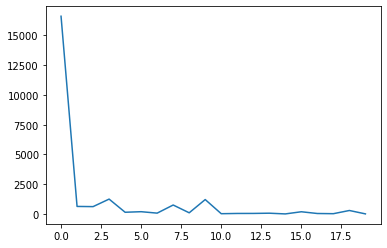

In [228]:
# Рвспределение токенов по чвстоте
pd.Series([freq_dict[key] for key in features.index[:20]]).plot()

Вывод: Также подтверждается вывод из предыдущего пугкта, что токены с низкой частотой имеют более важное прогностическое значение

# Задание 3

## 1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

In [229]:
# Обучим модель с count-векторайзером
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.80      0.76      0.78     29237
    positive       0.76      0.80      0.78     27472

    accuracy                           0.78     56709
   macro avg       0.78      0.78      0.78     56709
weighted avg       0.78      0.78      0.78     56709



In [230]:
# Обучим модель с tf-idf векторайзером
vec = TfidfVectorizer(ngram_range=(1, 1), stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.72      0.76      0.74     26246
    positive       0.78      0.74      0.76     30463

    accuracy                           0.75     56709
   macro avg       0.75      0.75      0.75     56709
weighted avg       0.75      0.75      0.75     56709



In [231]:
# Обучим модель c hashing векторайзером
vec = HashingVectorizer(analyzer='word', token_pattern=r'\w{1,}', n_features=200)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.66      0.62      0.64     29336
    positive       0.62      0.65      0.63     27373

    accuracy                           0.63     56709
   macro avg       0.64      0.64      0.63     56709
weighted avg       0.64      0.63      0.63     56709



In [232]:
# Обучим модель c полносвязанной нейронной сетью
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Conv1D, GRU, LSTM, Dropout
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [233]:
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

In [234]:
y_train

array([0, 0, 1, ..., 0, 0, 1])

In [235]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [236]:
train_data = train_data.batch(16)
valid_data = valid_data.batch(16)

In [237]:
for raw in train_data.take(1):
    pass

In [238]:
raw

(<tf.Tensor: shape=(16,), dtype=string, numpy=
 array([b'@mashashatskaya \xd1\x8f \xd0\xb5\xd1\x89\xd0\xb5 \xd0\xbf\xd0\xbe\xd0\xb4 \xd1\x82\xd0\xb5\xd0\xbf\xd0\xbb\xd1\x8b\xd0\xbc \xd0\xbe\xd0\xb4\xd0\xb5\xd1\x8f\xd0\xbb\xd0\xbe\xd0\xbc , -18??? \xd0\x96\xd0\xb5\xd1\x81\xd1\x82\xd1\x8c ;((((',
        b'RT @ZabilliKitarov: \xd0\x91\xd0\xbb\xd1\x8f\xd1\x82\xd1\x8c! \xd0\x9d\xd0\xb0\xd0\xbc \xd1\x83\xd0\xb6\xd0\xb5 \xd0\x9f\xd0\xb5\xd1\x88\xd0\xb5\xd1\x85\xd0\xbe\xd0\xb4\xd0\xbe\xd0\xb2\xd1\x8b \xd0\xb7\xd0\xb0\xd0\xb1\xd0\xb8\xd0\xb2\xd0\xb0\xd1\x8e\xd1\x82:(',
        b'\xd0\xb2\xd1\x81\xd1\x8e \xd0\xb6\xd0\xb8\xd0\xb7\xd0\xbd\xd1\x8c \xd1\x81\xd0\xbb\xd1\x83\xd1\x88\xd0\xb0\xd0\xbb\xd0\xb0 RAP,\xd0\xb0 \xd1\x82\xd1\x83\xd1\x82 \xd1\x87\xd1\x82\xd0\xbe-\xd1\x82\xd0\xbe \xd0\xbd\xd0\xb0 ROCK \xd0\xbf\xd0\xbe\xd0\xb4\xd1\x81\xd0\xb5\xd0\xbb\xd0\xb0)',
        b'RT @taigozin: \xd0\xa3 \xd0\xbc\xd0\xb5\xd0\xbd\xd1\x8f \xd0\xb1\xd1\x8b\xd0\xbb\xd0\xbe \xd1\x82\xd1\x80\xd1\x83\xd0\xb4\xd0\x

In [239]:
class myNet(tf.keras.Model):
    def __init__(self):
        super(myNet, self).__init__()
        self.emb = Embedding(vocab_size, embedding_dim, name="embedding")
        self.conv1 = Conv1D(200, (3))
        self.conv2 = Conv1D(200, (3))
        self.gPool = GlobalAveragePooling1D()
        self.fc1 = Dense(100, activation='relu')
        self.fc2 = Dense(1)


    def call(self, x):
        x = vectorize_layer(x)
        x = self.emb(x)
        x1 = self.conv1(x)
        x = self.conv2(x)
        x = self.gPool((x + x1)/2)
        x = self.fc1(x)
        return self.fc2(x)

In [240]:
mmodel = myNet()

In [241]:
mmodel.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [242]:
mmodel.fit(train_data, validation_data=valid_data, epochs=10)

Epoch 1/10
10633/10633 [==============================] - 68s 6ms/step - loss: 0.3902 - accuracy: 0.7749 - val_loss: 0.3651 - val_accuracy: 0.7686
Epoch 2/10
10633/10633 [==============================] - 68s 6ms/step - loss: 0.3284 - accuracy: 0.8179 - val_loss: 0.3443 - val_accuracy: 0.7981
Epoch 3/10
10633/10633 [==============================] - 67s 6ms/step - loss: 0.3072 - accuracy: 0.8324 - val_loss: 0.3463 - val_accuracy: 0.8058
Epoch 4/10
10633/10633 [==============================] - 67s 6ms/step - loss: 0.2885 - accuracy: 0.8447 - val_loss: 0.3591 - val_accuracy: 0.8047
Epoch 5/10
10633/10633 [==============================] - 67s 6ms/step - loss: 0.2671 - accuracy: 0.8584 - val_loss: 0.3882 - val_accuracy: 0.7867
Epoch 6/10
10633/10633 [==============================] - 67s 6ms/step - loss: 0.2459 - accuracy: 0.8712 - val_loss: 0.4602 - val_accuracy: 0.7730
Epoch 7/10
10633/10633 [==============================] - 67s 6ms/step - loss: 0.2277 - accuracy: 0.8834 - val_loss: 0

## 2) подобрать оптимальный размер для hashing векторайзера

In [243]:
# Поскольку выборка сбалансироанная определим лучшую модель по меитрике accuracy
from sklearn.metrics import accuracy_score
for n_features in range(1000000, 6000000, 1000000):
    vec = HashingVectorizer(analyzer='word', token_pattern=r'\w{1,}', n_features=n_features)
    bow = vec.fit_transform(x_train)
    clf = LogisticRegression(random_state=42)
    clf.fit(bow, y_train)
    pred = clf.predict(vec.transform(x_test))
    print(f'При n_features = {n_features}, accuracy_score = {accuracy_score(pred, y_test)}')

При n_features = 1000000, accuracy_score = 0.7724170766544993
При n_features = 2000000, accuracy_score = 0.7731753337212788
При n_features = 3000000, accuracy_score = 0.7730518965243612
При n_features = 4000000, accuracy_score = 0.7728579237863479
При n_features = 5000000, accuracy_score = 0.7729460932127176


Наибольший accuracy_score был достигнут при n_features равном 2000000

## 3) убедиться что для сетки нет переобучения

Если посмотрим на метрики в процессе обучения сети, то можно заметить, что начиная с 3 эпохи accuracy на обучающей выборке продолжает расти, а на тестовой начинает снижаться. С этого момента модель и начинает переобучаться. Сдедаовательно оптимальное количество эпох для данной нейросети 3.